------------------------------------------------------------------------
##### Importing Packages
------------------------------------------------------------------------

In [177]:
import GPy, numpy as np # Gaussian Process package
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler # features scaling
import pandas as pd
np.random.seed(1) # for reproducibility
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

------------------------------------------------------------------------
##### Generating the date range to get the time series input domain
------------------------------------------------------------------------

In [178]:
# Define the date range
start_date = '1999-01-01'
end_date = '2005-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Reference date (January 1970)
reference_date = pd.Timestamp('1999-01-01')

# Calculate the number of months since the reference date
months_since_reference = (date_range.year - reference_date.year) * 12 + (date_range.month - reference_date.month)

# Output the dates and their corresponding months since the reference date
month_array = []
for date, months in zip(date_range, months_since_reference):
    print(f"Date: {date}, Months since reference: {months}")
    month_array.append(months)
np.array(month_array)

Date: 1999-01-31 00:00:00, Months since reference: 0
Date: 1999-02-28 00:00:00, Months since reference: 1
Date: 1999-03-31 00:00:00, Months since reference: 2
Date: 1999-04-30 00:00:00, Months since reference: 3
Date: 1999-05-31 00:00:00, Months since reference: 4
Date: 1999-06-30 00:00:00, Months since reference: 5
Date: 1999-07-31 00:00:00, Months since reference: 6
Date: 1999-08-31 00:00:00, Months since reference: 7
Date: 1999-09-30 00:00:00, Months since reference: 8
Date: 1999-10-31 00:00:00, Months since reference: 9
Date: 1999-11-30 00:00:00, Months since reference: 10
Date: 1999-12-31 00:00:00, Months since reference: 11
Date: 2000-01-31 00:00:00, Months since reference: 12
Date: 2000-02-29 00:00:00, Months since reference: 13
Date: 2000-03-31 00:00:00, Months since reference: 14
Date: 2000-04-30 00:00:00, Months since reference: 15
Date: 2000-05-31 00:00:00, Months since reference: 16
Date: 2000-06-30 00:00:00, Months since reference: 17
Date: 2000-07-31 00:00:00, Months sinc

 C:\Users\taadebi2\AppData\Local\Temp\ipykernel_24660\101146012.py:4: FutureWarning:'M' is deprecated and will be removed in a future version, please use 'ME' instead.


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

------------------------------------------------------------------------
##### Generating the pressure dataset
------------------------------------------------------------------------

X_data_shape:
 (73, 1)


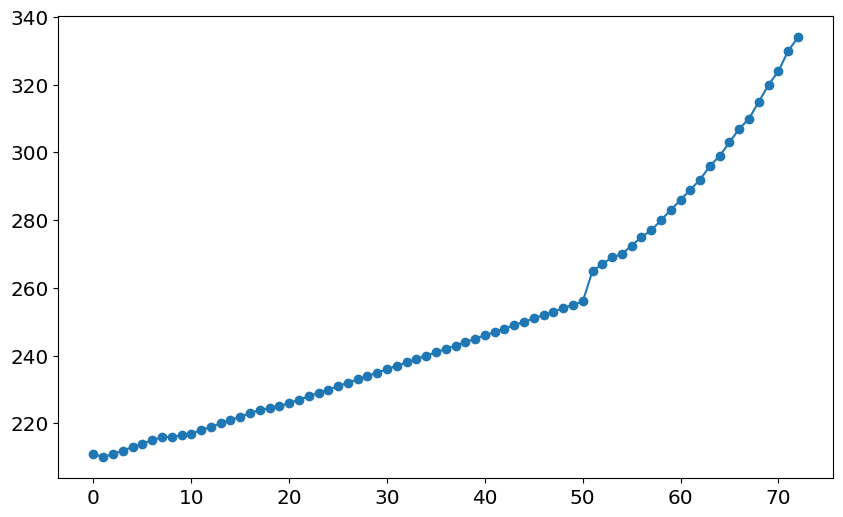

In [179]:
X_data = np.array(month_array).reshape(-1,1)
print(f'X_data_shape:\n {X_data.shape}')

# Load the CSV file
csv_file_path = 'C:/Users/taadebi2/Downloads/pressure_data.csv'  # Path to your CSV file
df = pd.read_csv(csv_file_path)

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Slice out Y_data
Y_data = data_array[:, 1].reshape(-1,1)


plt.rcParams['figure.figsize'] = (10, 6)  # Change the tuple to your desired size (width, height) in inches
plt.scatter(X_data, Y_data)
plt.plot(X_data, Y_data)

Text(0.5, 1.0, 'Time-Series Pressure Data')

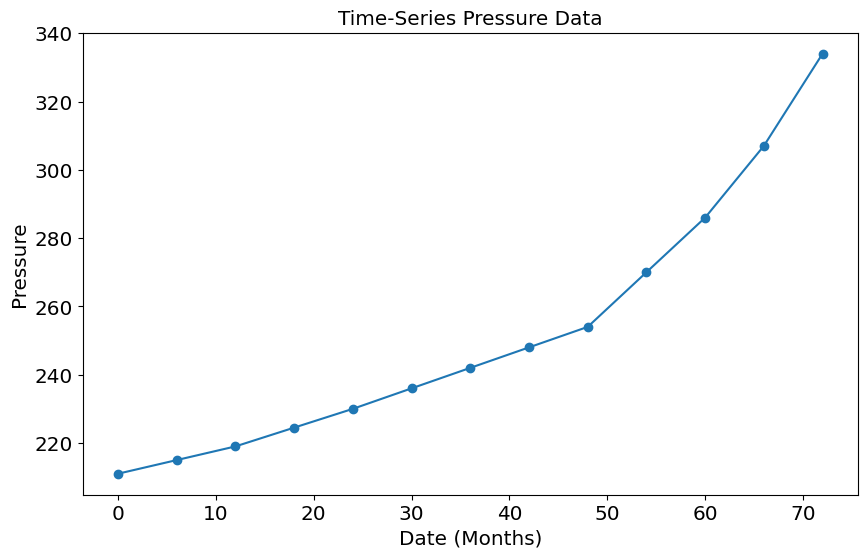

In [180]:
X = []
for i in range(0,73,6):
    X.append(X_data[i])
X = np.array(X)

Y = []
for i in range(0,73,6):
    Y.append(Y_data[i])
Y = np.array(Y)


plt.rcParams['figure.figsize'] = (10, 6)  # Change the tuple to your desired size (width, height) in inches
plt.scatter(X, Y)
plt.plot(X, Y)
plt.xlabel('Date (Months)')
plt.ylabel('Pressure')
#plt.legend(loc='upper left')
plt.title('Time-Series Pressure Data')
#plt.show()

------------------------------------------------------------------------
##### Exploring GP kernels and subsequently selecting the most appropriate for the datasets.
------------------------------------------------------------------------

###### A range of kernels are implemented in the GPy package as listed below:

- RBF (exponentiated quadratic, squared exponential, or any other name you wish to give it)
- Linear
- Bias
- Matern52
- Matern32
- Polynomial
- Brownian
- MLP
- Exponential
- Standard periodic

###### A 1D plot for each kernel representation at default hyperparameter settings are given below:

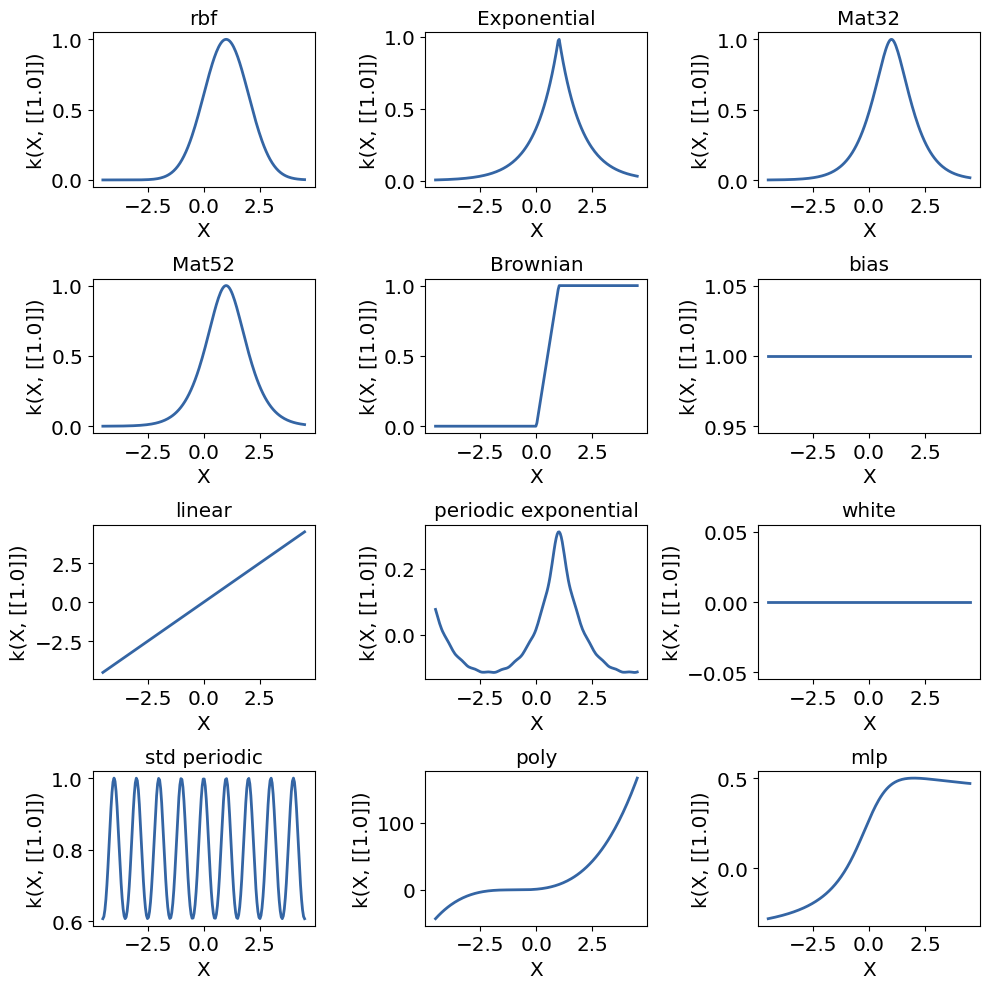

In [181]:
# A full list can be found by doing GPy.kern.<tab>
figure, axes = plt.subplots(4,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), 
         GPy.kern.Matern52(1), GPy.kern.Brownian(1),GPy.kern.Bias(1), 
         GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1), 
         GPy.kern.StdPeriodic(1), GPy.kern.Poly(1), GPy.kern.MLP(1)]

for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))
plt.savefig('kernels.png', bbox_inches='tight')

###### For the given datasets, we will combine the linear and radiabl basis function (RBF also called squared-exponential) kernels to capture the observed linearity and smoothness in the datasets.

sum.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
poly.variance,1.0,+ve,
poly.scale,1.0,+ve,
poly.bias,1.0,+ve,


{'covariance': [[<matplotlib.lines.Line2D at 0x23309a17c90>]]}

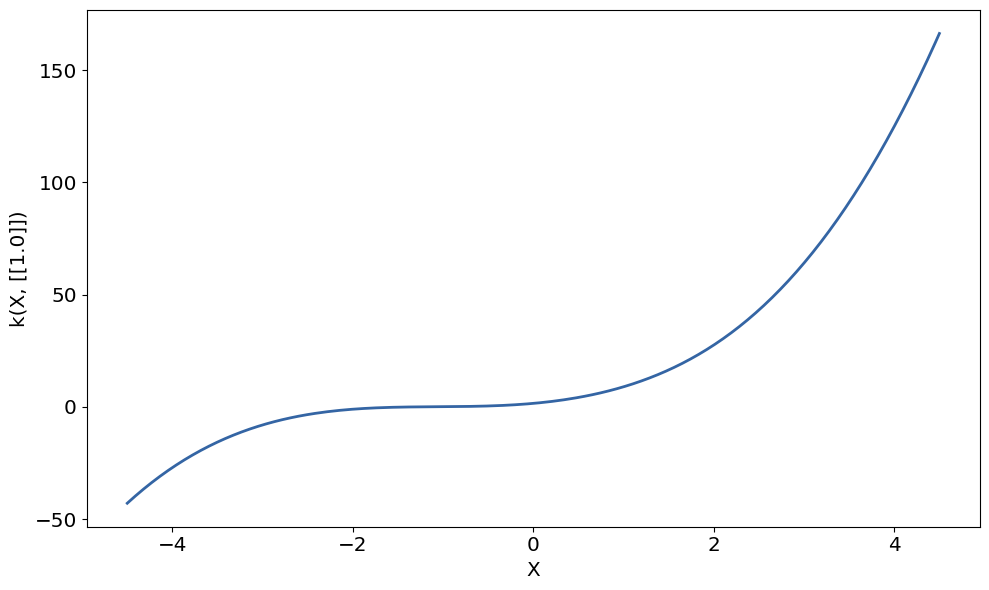

In [182]:
# Creating the combined kernel
#kern1 = GPy.kern.Linear(input_dim=1)
kern1 = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1)
kern2 = GPy.kern.Poly(input_dim=1)
kern = kern1 + kern2
display(kern)

kern.plot()

##### Now we compute the covariance function of the kernel on the given datasets

[[2.00000000e+00 1.00000002e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [1.00000002e+00 5.06540000e+04 3.89017000e+05 1.29502900e+06
  3.04862500e+06 5.92974100e+06 1.02183130e+07 1.61942770e+07
  2.41375690e+07 3.43281250e+07 4.70458810e+07 6.25707730e+07
  8.11827370e+07]
 [1.00000000e+00 3.89017000e+05 3.04862600e+06 1.02183130e+07
  2.41375690e+07 4.70458810e+07 8.11827370e+07 1.28787625e+08
  1.92100033e+08 2.73359449e+08 3.74805361e+08 4.98677257e+08
  6.47214625e+08]
 [1.00000000e+00 1.29502900e+06 1.02183130e+07 3.43281260e+07
  8.11827370e+07 1.58340421e+08 2.73359449e+08 4.33798093e+08
  6.47214625e+08 9.21167317e+08 1.26321444e+09 1.68091427e+09
  2.18182507e+09]
 [1.00000000e+00 3.04862500e+06 2.41375690e+07 8.11827370e+07
  1.92100034e+08 3.74805361e+08 6.47214625e+08 1.02724373e+09
  1.53280858e+09 2.18182507e+09 2.99220912e+09 3.98187662e+0

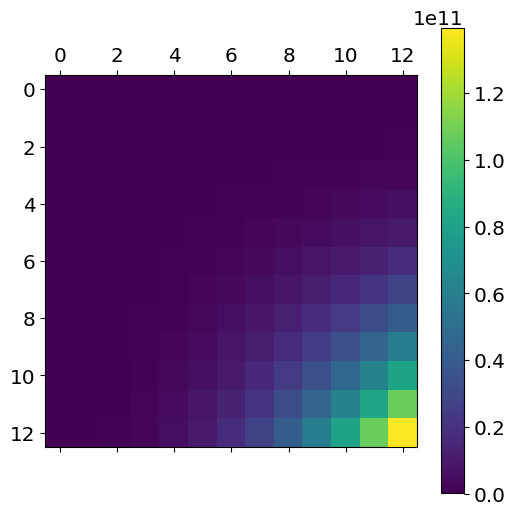

In [183]:
print(kern.K(X))
plt.matshow(kern.K(X))
plt.colorbar()

-------------------------------------------------------------------------
##### Create Gaussian Process model with noise
-------------------------------------------------------------------------

In [184]:
noise_var = 0.1  # Initial noise variance
model = GPy.models.GPRegression(X, Y, kern, noise_var=noise_var)

display(model)

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,1.0,+ve,
sum.poly.variance,1.0,+ve,
sum.poly.scale,1.0,+ve,
sum.poly.bias,1.0,+ve,
Gaussian_noise.variance,0.1,+ve,


##### Plotting the unoptimized model which will most likely not fit model

Text(0, 0.5, 'Pressure[bar]')

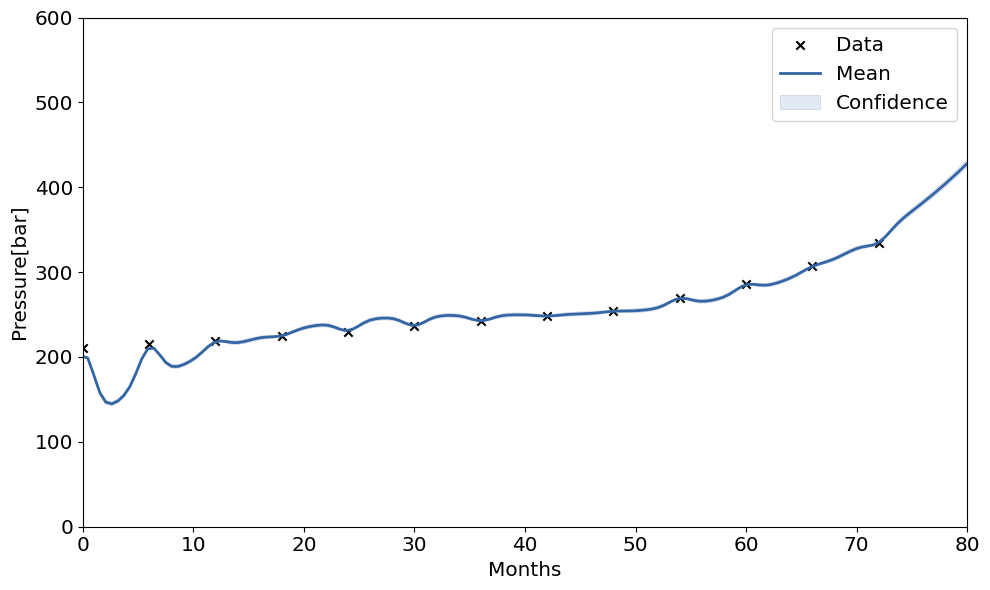

In [185]:
model.plot()
plt.xlim(0, 80)
plt.ylim(0, 600)
plt.xlabel('Months')
plt.ylabel('Pressure[bar]')

Of course the default parameter values are not the optimal settings, as such we need to optimize them.

###### Performing model optimization

In [186]:
#model.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed
model.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 42.470344979627285
Optimization restart 2/10, f = 42.470345049681576
Optimization restart 3/10, f = 42.470345049675274
Optimization restart 4/10, f = 42.47034504968919
Optimization restart 5/10, f = 42.470344975952344
Optimization restart 6/10, f = 42.47034504966931
Optimization restart 7/10, f = 42.47034504967924
Optimization restart 8/10, f = 42.47034504992461
Optimization restart 9/10, f = 38.90918308599294
Optimization restart 10/10, f = 42.470344816284786


##### Plotting the optimized model

Text(0, 0.5, 'Pressure[bar]')

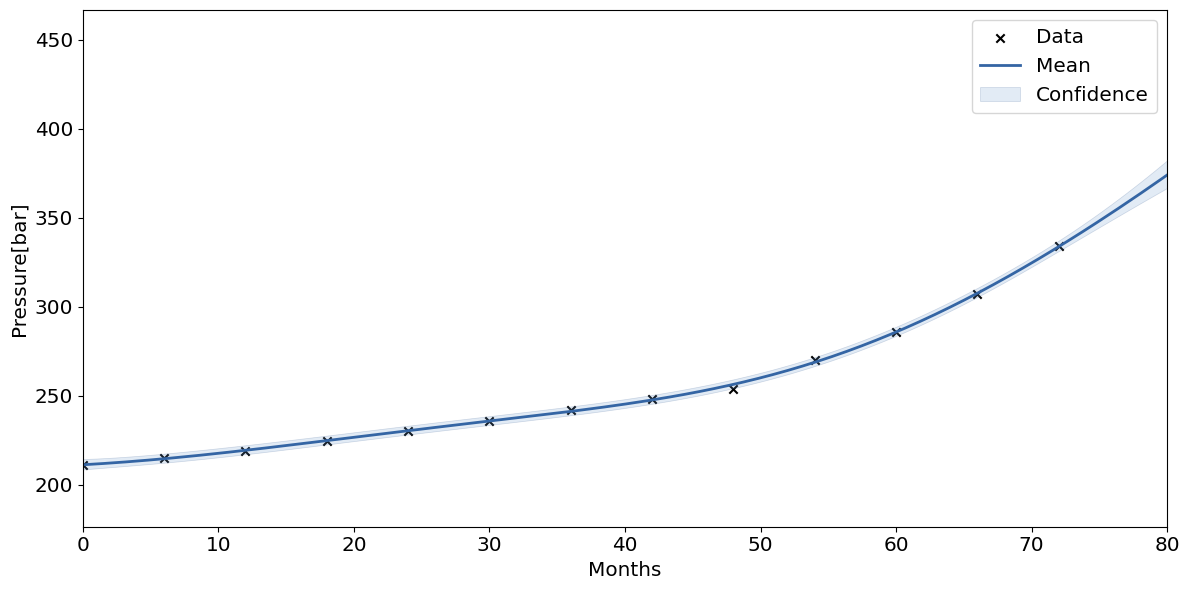

In [187]:
#plt.rcParams['figure.figsize'] = (10, 6)  # Change the tuple to your desired size (width, height) in inches
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
model.plot()
plt.xlim(0, 80)
plt.xlabel('Months')
plt.ylabel('Pressure[bar]')


#fig.savefig('test.jpg')

As expected, the model fit the datasets well enough and the predicitve mean uncertanties collapse at the data points as expected. Thus the model will be good for interplatory prediction and will perform well with minimal uncertainties several months or few years extrapolatory prediction.

Index([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], dtype='int32')
(array([[333.72488447]]), array([[2.24127766]]))


 C:\Users\taadebi2\AppData\Local\Temp\ipykernel_24660\619744425.py:2: FutureWarning:'M' is deprecated and will be removed in a future version, please use 'ME' instead.


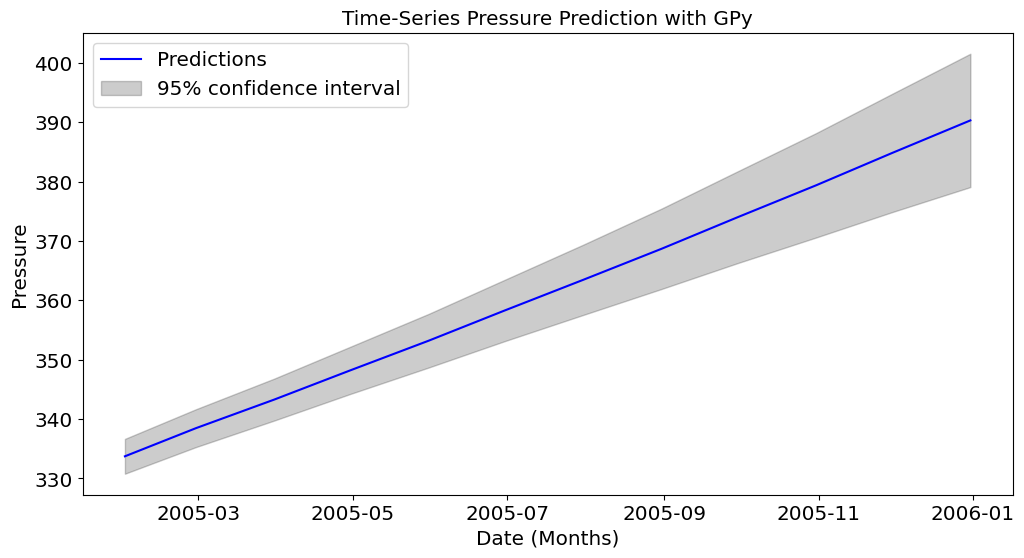

In [188]:
# Predict future values
future_dates = pd.date_range(start='2005-01-01', periods=12, freq='M')
future_months_since_reference = (future_dates.year - reference_date.year) * 12 + (future_dates.month - reference_date.month)
print(future_months_since_reference)
future_X = future_months_since_reference.values.reshape(-1, 1)
print(model.predict(np.array([[72]])))
future_Y, future_Y_var = model.predict(future_X)

# Plot the future predictions
plt.figure()
#plt.plot(dates, values, 'r.', markersize=10, label='Observations')
plt.plot(future_dates, future_Y, 'b-', label='Predictions')
plt.fill_between(future_dates,
                 (future_Y - 1.96 * np.sqrt(future_Y_var)).flatten(),
                 (future_Y + 1.96 * np.sqrt(future_Y_var)).flatten(),
                 alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('Date (Months)')
plt.ylabel('Pressure')
plt.legend(loc='upper left')
plt.title('Time-Series Pressure Prediction with GPy')
plt.show()

In [189]:
Y_data[72]

array([334.])

#### Generate test data

In [190]:
X_test = []
Y_test = []

for i in range(1,60,2):
        X_test.append(X_data[i])
X_test = np.array(X_test)

for i in range(1,60,2):
    Y_test.append(Y_data[i])
Y_test = np.array(Y_test)
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_test.shape: (30, 1)
Y_test.shape: (30, 1)


In [191]:
X_test = []
Y_test = []

for i in range(1,60,2):
        X_test.append(X_data[i])
X_test = np.array(X_test)

for i in range(1,60,2):
    Y_test.append(Y_data[i])
Y_test = np.array(Y_test)
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_test.shape: (30, 1)
Y_test.shape: (30, 1)


#### Assessing Model Performance via Interploation for unseen data

In [192]:
# Make predictions on the test set
Y_pred, Y_pred_var = model.predict(X_test)

# Compute error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score (Coefficient of Determination):", r2)

Mean Squared Error (MSE): 1.2785752376330377
Mean Absolute Error (MAE): 0.7863340700996863
Root Mean Squared Error (RMSE): 1.1307410126253659
R² Score (Coefficient of Determination): 0.9968026204552737


In [193]:
# Make predictions on the test set
for i,j in zip(Y_pred, Y_pred_var):
    print(f'predicted value: {i}, variance:{j}')

predicted value: [211.59462105], variance:[1.97778449]
predicted value: [212.64443705], variance:[1.73712216]
predicted value: [213.86761039], variance:[1.67761707]
predicted value: [215.24931666], variance:[1.67929502]
predicted value: [216.7709897], variance:[1.68513149]
predicted value: [218.41093086], variance:[1.67672317]
predicted value: [220.14517989], variance:[1.65552736]
predicted value: [221.94862449], variance:[1.62998123]
predicted value: [223.79630678], variance:[1.60799622]
predicted value: [225.66486689], variance:[1.59374923]
predicted value: [227.53404916], variance:[1.58741593]
predicted value: [229.38818559], variance:[1.58649923]
predicted value: [231.21756543], variance:[1.58763253]
predicted value: [233.01960069], variance:[1.58808843]
predicted value: [234.79970442], variance:[1.58660252]
predicted value: [236.57181196], variance:[1.58345007]
predicted value: [238.35849468], variance:[1.57994553]
predicted value: [240.19063916], variance:[1.57765555]
predicted v

------------------------------------------------------------------------
##### Generating the oil production rate dataset
------------------------------------------------------------------------

oil_prod_data_shape: (79, 2)
time_data_shape: (79, 1)
oil_prod_data_shape: (79, 1)


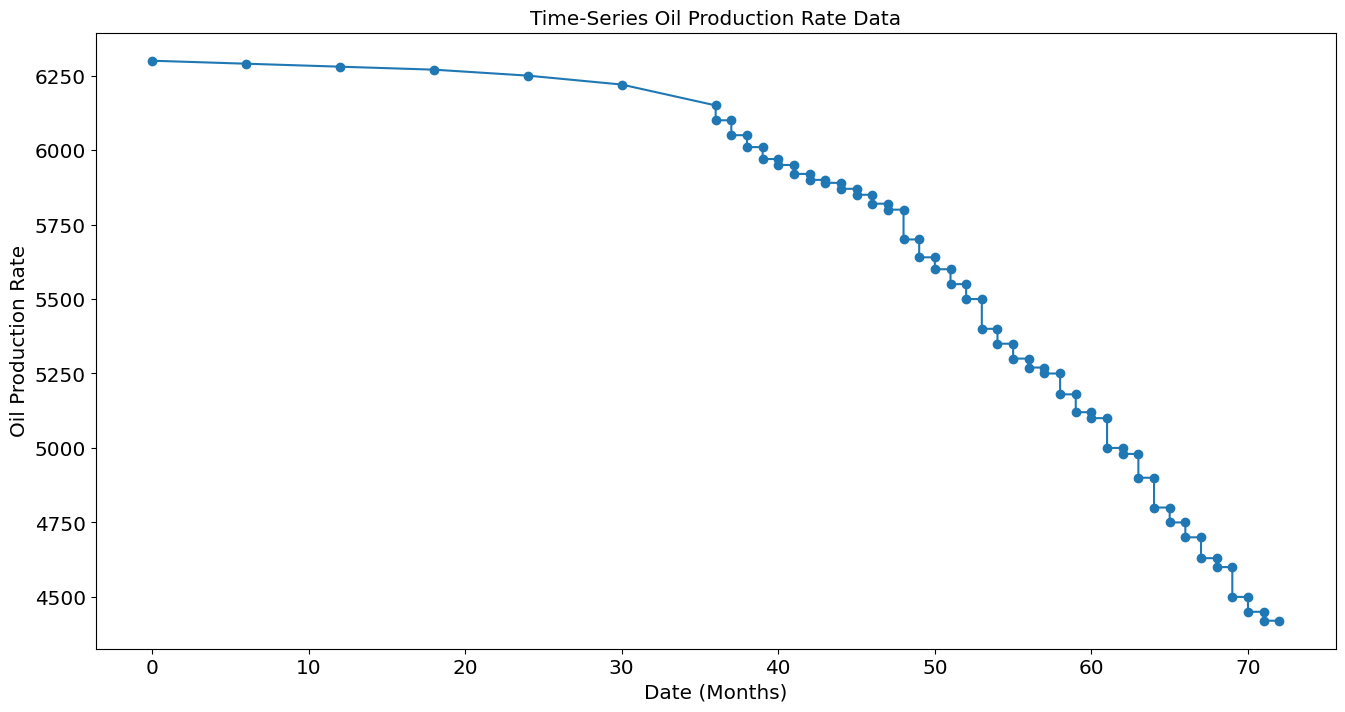

In [194]:
#production_data = ['Month', 'Water', 'Oil', 'Gas']

# Load the CSV file
csv_file_path = 'C:/Users/taadebi2/Downloads/oil_data.csv'  # Path to your CSV file
df = pd.read_csv(csv_file_path)

# Convert the DataFrame to a NumPy array
oil_data_array = df.to_numpy()
print(f'oil_prod_data_shape: {oil_data_array.shape}')

# Slice out months data
time_data = oil_data_array[:, 0].reshape(-1,1)
print(f'time_data_shape: {time_data.shape}')

# Slice out water production data
oil_prod_data = oil_data_array[:, 1].reshape(-1,1)
print(f'oil_prod_data_shape: {oil_prod_data.shape}')


plt.rcParams['figure.figsize'] = (16, 8)  # Change the tuple to your desired size (width, height) in inches
plt.scatter(time_data, oil_prod_data)
plt.plot(time_data, oil_prod_data)
plt.xlabel('Date (Months)')
plt.ylabel('Oil Production Rate')
#plt.legend(loc='upper left')
plt.title('Time-Series Oil Production Rate Data')
plt.savefig("oil_production_data.pdf", format="pdf", bbox_inches="tight")

###### For the given datasets, we will combine the Matern32 and radiabl basis function (RBF also called squared-exponential) kernels to capture the observed discontinuities and slight smoothness in the datasets.

sum.,value,constraints,priors
Mat32.variance,1.0,+ve,
Mat32.lengthscale,1.0,+ve,
Brownian.variance,1.0,+ve,


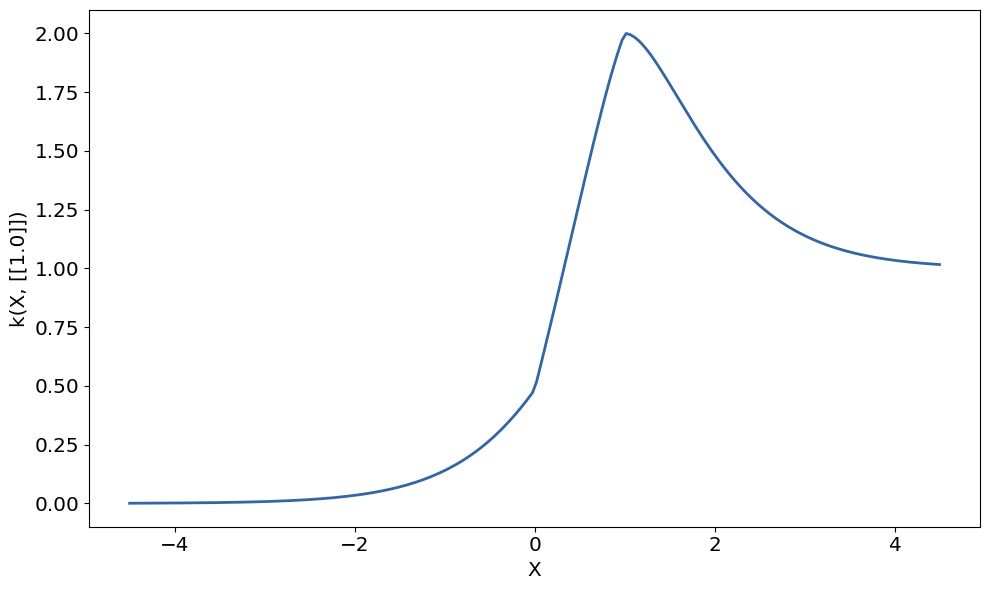

In [195]:
# Creating the combined kernel

kern1 = GPy.kern.Matern32(input_dim=1, variance=1., lengthscale=1)
kern2 = GPy.kern.Brownian(input_dim=1)
kern = kern1 + kern2
display(kern)

plt.rcParams['figure.figsize'] = (10, 6)
kern.plot()
plt.savefig("oil_prod_kern_plot.png", format="png", bbox_inches="tight")

##### Now we compute the covariance function of the kernel on the given datasets

[[1.00000000e+00 3.49374295e-04 2.04884208e-08 ... 4.84962959e-52
  4.84962959e-52 8.69989382e-53]
 [3.49374295e-04 7.00000000e+00 6.00034937e+00 ... 6.00000000e+00
  6.00000000e+00 6.00000000e+00]
 [2.04884208e-08 6.00034937e+00 1.30000000e+01 ... 1.20000000e+01
  1.20000000e+01 1.20000000e+01]
 ...
 [4.84962959e-52 6.00000000e+00 1.20000000e+01 ... 7.20000000e+01
  7.20000000e+01 7.14833577e+01]
 [4.84962959e-52 6.00000000e+00 1.20000000e+01 ... 7.20000000e+01
  7.20000000e+01 7.14833577e+01]
 [8.69989382e-53 6.00000000e+00 1.20000000e+01 ... 7.14833577e+01
  7.14833577e+01 7.30000000e+01]]


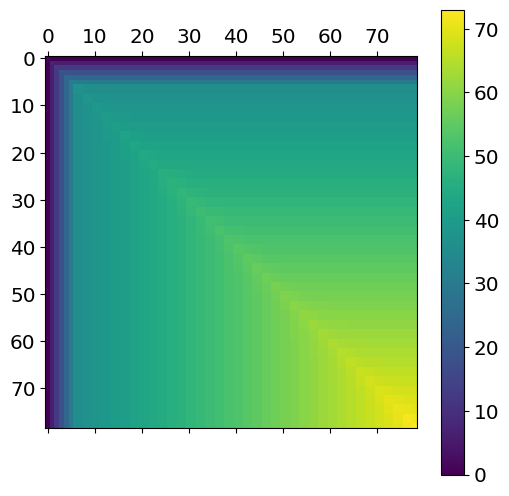

In [196]:
print(kern.K(time_data))
plt.matshow(kern.K(time_data))
plt.colorbar()
plt.savefig("oil_prod_cov_plot.png", format="png", bbox_inches="tight")

In [197]:
noise_var = 0.1  # Initial noise variance
oil_prod_model = GPy.models.GPRegression(time_data, oil_prod_data, kern, noise_var=noise_var)

display(oil_prod_model)

GP_regression.,value,constraints,priors
sum.Mat32.variance,1.0,+ve,
sum.Mat32.lengthscale,1.0,+ve,
sum.Brownian.variance,1.0,+ve,
Gaussian_noise.variance,0.1,+ve,


##### Plotting the unoptimized model which will most likely not fit model

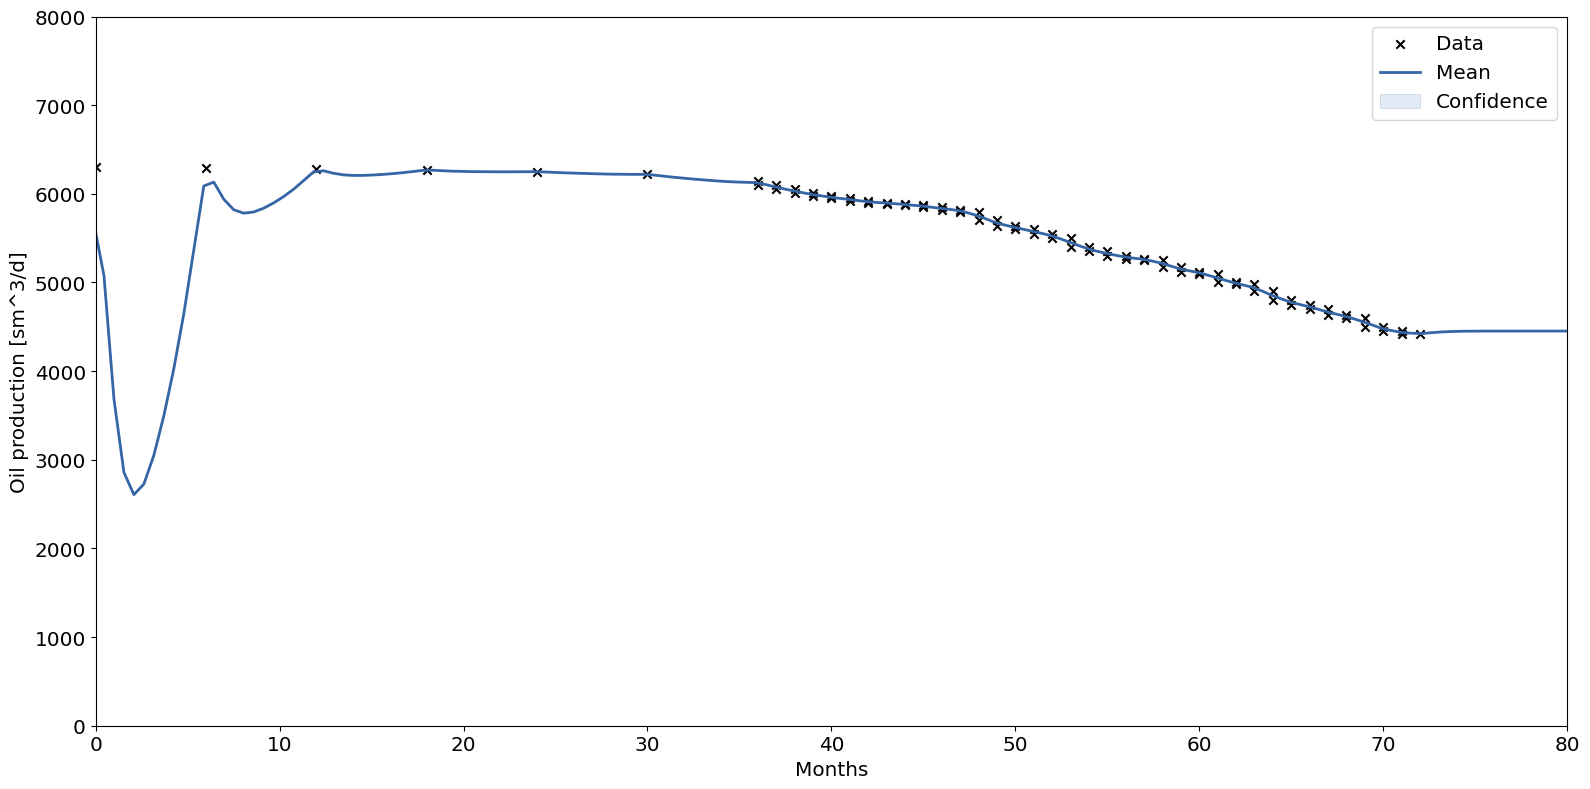

In [198]:
plt.rcParams['figure.figsize'] = (16, 8)  # Change the tuple to your desired size (width, height) in inches
oil_prod_model.plot()
plt.xlim(0, 80)
plt.ylim(0, 8000)
plt.xlabel('Months')
plt.ylabel('Oil production [sm^3/d]')
plt.savefig("unoptim_oil_prod_GP.pdf", format="pdf", bbox_inches="tight")

In [199]:
#model.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed
oil_prod_model.optimize_restarts(num_restarts = 70)

Optimization restart 1/70, f = 440.2347718775581
Optimization restart 2/70, f = 444.2640829315395
Optimization restart 3/70, f = 439.9375958267738
Optimization restart 4/70, f = 439.9713344057431
Optimization restart 5/70, f = 439.94048446704693
Optimization restart 6/70, f = 439.94043376195765
Optimization restart 7/70, f = 440.27051588607014
Optimization restart 8/70, f = 439.94601600204453
Optimization restart 9/70, f = 441.01316031647264
Optimization restart 10/70, f = 439.94176757370303
Optimization restart 11/70, f = 439.9406194957088
Optimization restart 12/70, f = 439.9404031865268
Optimization restart 13/70, f = 439.9472460893269


 C:\Users\taadebi2\Desktop\TSRoots\Lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in divide
 C:\Users\taadebi2\Desktop\TSRoots\Lib\site-packages\GPy\kern\src\stationary.py:489: RuntimeWarning:overflow encountered in multiply
 C:\Users\taadebi2\Desktop\TSRoots\Lib\site-packages\GPy\kern\src\stationary.py:489: RuntimeWarning:invalid value encountered in multiply
 C:\Users\taadebi2\Desktop\TSRoots\Lib\site-packages\GPy\kern\src\stationary.py:492: RuntimeWarning:overflow encountered in multiply
 C:\Users\taadebi2\Desktop\TSRoots\Lib\site-packages\GPy\kern\src\stationary.py:492: RuntimeWarning:invalid value encountered in multiply


Optimization restart 14/70, f = 449.1415406904605
Optimization restart 15/70, f = 440.22060422364245
Optimization restart 16/70, f = 441.8239458218655
Optimization restart 17/70, f = 572.1043711923832
Optimization restart 18/70, f = 439.9404632240618
Optimization restart 19/70, f = 439.94041321444763
Optimization restart 20/70, f = 439.94047191790594
Optimization restart 21/70, f = 443.0986933488517
Optimization restart 22/70, f = 439.940424465233
Optimization restart 23/70, f = 440.0418217739883
Optimization restart 24/70, f = 439.94055085090184
Optimization restart 25/70, f = 439.9931613583584
Optimization restart 26/70, f = 439.94042819199973
Optimization restart 27/70, f = 439.9404286263341
Optimization restart 28/70, f = 412.76822468113346
Optimization restart 29/70, f = 440.6590246945115
Optimization restart 30/70, f = 439.94074260897287
Optimization restart 31/70, f = 411.6310833888493
Optimization restart 32/70, f = 439.9929308714076
Optimization restart 33/70, f = 439.94163060

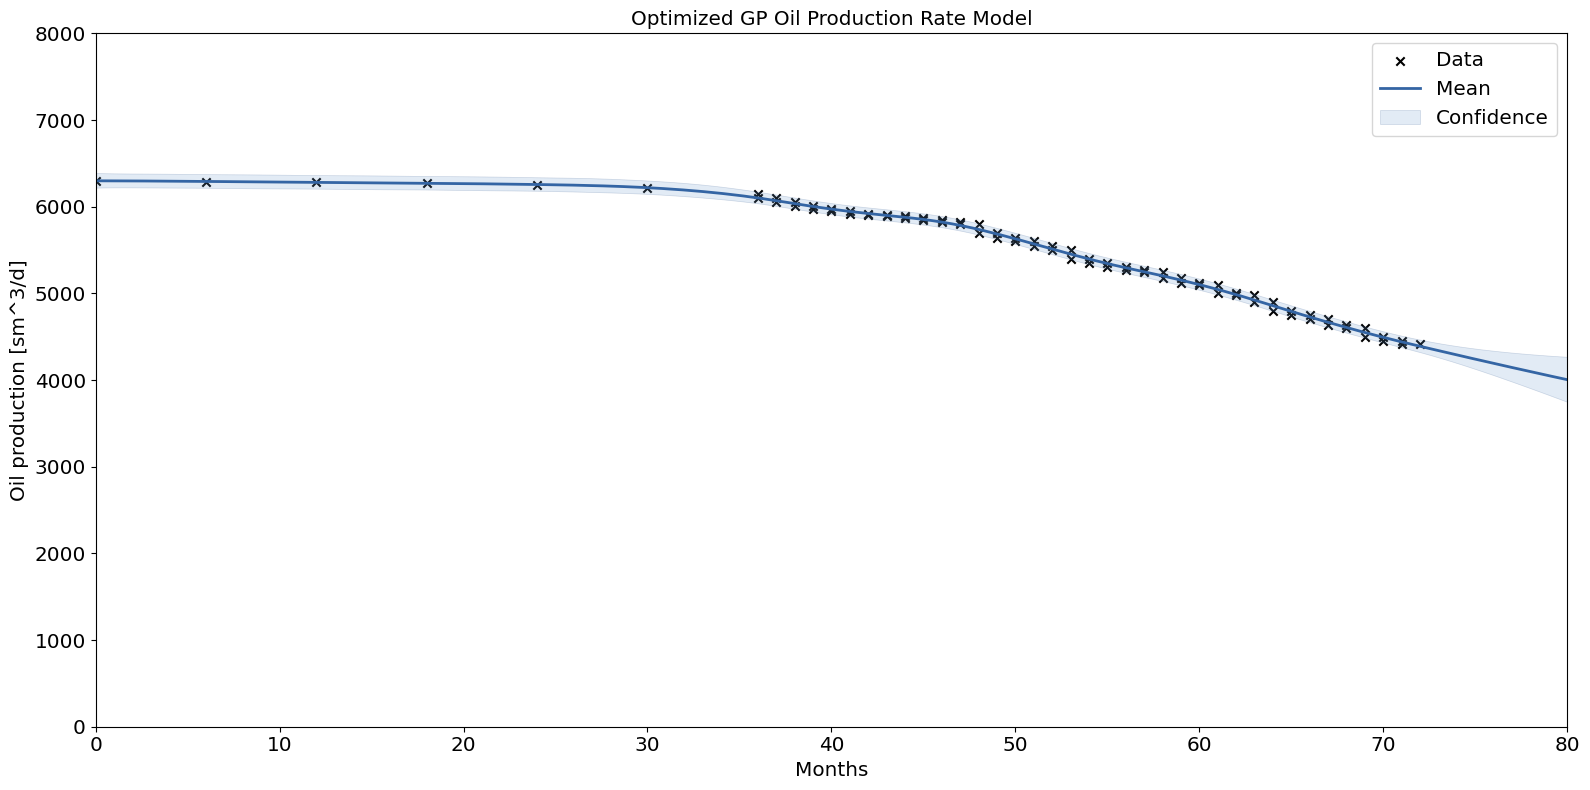

In [200]:
#plt.rcParams['figure.figsize'] = (10, 6)  # Change the tuple to your desired size (width, height) in inches
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
oil_prod_model.plot()
plt.xlim(0, 80)
plt.ylim(0, 8000)
plt.xlabel('Months')
plt.ylabel('Oil production [sm^3/d]')

plt.title('Optimized GP Oil Production Rate Model')
plt.savefig("optim_oil_prod_GP.png", format="png", bbox_inches="tight")
#fig.savefig('test.jpg')

#### Generate test data

In [201]:
X_test = []
Y_test = []

for i in range(1,60,2):
        X_test.append(time_data[i])
X_test = np.array(X_test)

for i in range(1,60,2):
    Y_test.append(oil_prod_data[i])
Y_test = np.array(Y_test)
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_test.shape: (30, 1)
Y_test.shape: (30, 1)


Index([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], dtype='int32')
(array([[4389.36124189]]), array([[1341.56495716]]))


 C:\Users\taadebi2\AppData\Local\Temp\ipykernel_24660\392301212.py:2: FutureWarning:'M' is deprecated and will be removed in a future version, please use 'ME' instead.


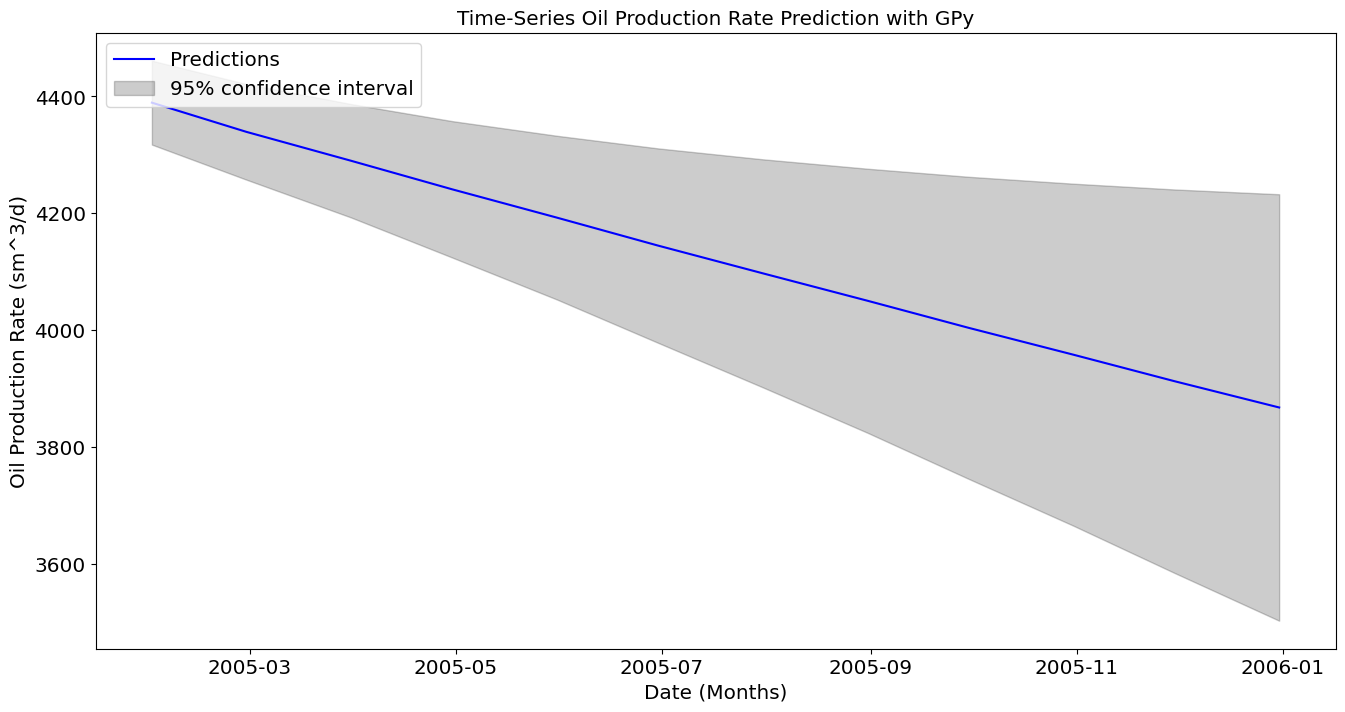

In [202]:
# Predict future values
future_dates = pd.date_range(start='2005-01-01', periods=12, freq='M')
future_months_since_reference = (future_dates.year - reference_date.year) * 12 + (future_dates.month - reference_date.month)
print(future_months_since_reference)
future_X = future_months_since_reference.values.reshape(-1, 1)
print(oil_prod_model.predict(np.array([[72]])))
future_Y, future_Y_var = oil_prod_model.predict(future_X)

# Plot the future predictions
plt.figure()
#plt.plot(dates, values, 'r.', markersize=10, label='Observations')
plt.plot(future_dates, future_Y, 'b-', label='Predictions')
plt.fill_between(future_dates,
                 (future_Y - 1.96 * np.sqrt(future_Y_var)).flatten(),
                 (future_Y + 1.96 * np.sqrt(future_Y_var)).flatten(),
                 alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('Date (Months)')
plt.ylabel('Oil Production Rate (sm^3/d)')
plt.legend(loc='upper left')
plt.title('Time-Series Oil Production Rate Prediction with GPy')
plt.savefig("pred_GP_oil_prod_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Assessing Model Performance via Interploation for unseen data

In [203]:
# Make predictions on the test set
Y_pred, Y_pred_var = oil_prod_model.predict(X_test)

# Compute error metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score (Coefficient of Determination):", r2)

Mean Squared Error (MSE): 671.9690554573766
Mean Absolute Error (MAE): 20.312482739527088
Root Mean Squared Error (RMSE): 25.922365930936486
R² Score (Coefficient of Determination): 0.9954440888329713


In [204]:
# Make predictions on the test set
for i,j in zip(Y_pred, Y_pred_var):
    print(f'predicted value: {i}, variance:{j}')

predicted value: [6291.12227174], variance:[1616.87024241]
predicted value: [6270.27190572], variance:[1586.75733224]
predicted value: [6219.32146713], variance:[1545.94362922]
predicted value: [6101.09962242], variance:[1161.03104769]
predicted value: [6069.21083113], variance:[1106.51031552]
predicted value: [6035.43799821], variance:[1083.56987497]
predicted value: [6002.29045752], variance:[1076.93429159]
predicted value: [5971.80194055], variance:[1075.9447697]
predicted value: [5944.88860296], variance:[1076.0072054]
predicted value: [5921.29889491], variance:[1075.94937219]
predicted value: [5899.72685704], variance:[1075.7660321]
predicted value: [5877.85982557], variance:[1075.60185322]
predicted value: [5852.91256049], variance:[1075.50844853]
predicted value: [5822.28324092], variance:[1075.47068784]
predicted value: [5784.09665297], variance:[1075.46034149]
predicted value: [5737.88831775], variance:[1075.45900064]
predicted value: [5685.35502668], variance:[1075.45913532]
